In [ ]:
# Percentage difference vs statevector:
# Reads /mnt/data/init_expvals.csv (columns: graph_id, N, depth, seed, method, exp_value)
# Computes %Δ(method) = 100 * (method - SV) / max(|SV|, eps) per (graph_id,N,depth,seed),
# aggregates mean ± std over (graph_id, seed), and plots a small-multiples grid by depth.

import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "ex_value_pots/init_expvals.csv"
OUT_GRID = "data/init_pctdiff_grid.png"
OUT_CSV  = "data/init_pctdiff_summary.csv"

# ---- Load ----
df = pd.read_csv(CSV_PATH)

def canon(m):
    m = str(m).strip().lower()
    if m in ["sv", "statevector", "contraction", "contract"]:
        return "SV"
    if m in ["tr_expectation", "tr-expectation", "contraction_tr"]:
        return "TR-expectation"
    if m in ["tr_sampling", "sampling"]:
        return "TR-sampling"
    if m in ["tr_correct_sampling", "tr-correct-sampling", "trcorrect", "tr_correct"]:
        return "TR-correct"
    return m

df["method"] = df["method"].map(canon)

# ---- Join SV and compute per-sample %diff ----
sv = df[df["method"]=="SV"][["graph_id","N","depth","seed","exp_value"]].rename(columns={"exp_value":"sv_value"})
others = df[df["method"]!="SV"][["graph_id","N","depth","seed","method","exp_value"]].rename(columns={"exp_value":"value"})
merged = others.merge(sv, on=["graph_id","N","depth","seed"], how="left")

eps = 1e-9
denom = np.maximum(np.abs(merged["sv_value"].to_numpy(dtype=float)), eps)
pct = 100.0 * (merged["value"].to_numpy(dtype=float) - merged["sv_value"].to_numpy(dtype=float)) / denom
merged["pct_diff"] = pct

# ---- Aggregate mean/std over (graph_id, seed) ----
agg = merged.groupby(["depth","N","method"]).agg(
    mean_pct=("pct_diff","mean"),
    std_pct=("pct_diff","std"),
    count=("pct_diff","size")
).reset_index()

# Save summary CSV and preview
agg.to_csv(OUT_CSV, index=False)
#cj.display_dataframe_to_user("Percentage difference vs SV (mean±std)", agg.sort_values(["depth","N","method"]).head(40))

# ---- Plot grid by depth ----
methods_order = ["TR-expectation","TR-correct"]
method_labels = {
    "TR-expectation": "Contraction",
    "TR-sampling": "Sampling",
    "TR-correct": "Perfect Sampling w/ Right Suffix",
}
colors = {
    "TR-expectation": "#1f77b4",
    "TR-sampling": "#ff7f0e",
    "TR-correct": "#2ca02c",
}

depths = sorted(agg["depth"].unique())
K = len(depths)
cols = 3 if K >= 3 else K
rows = math.ceil(K / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4.0*cols, 3.3*rows), sharex=True, sharey=True)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])
axes = axes.flatten()

for i, d in enumerate(depths):
    ax = axes[i]
    sub = agg[agg["depth"] == d]
    for m in methods_order:
        sm = sub[sub["method"] == m].sort_values("N")
        if sm.empty:
            continue
        x = sm["N"].to_numpy()
        y = sm["mean_pct"].to_numpy()
        e = sm["std_pct"].to_numpy()
        ax.errorbar(x, y, yerr=e, capsize=4, label=method_labels[m], color=colors[m])
    ax.set_title(f"Depth = {d}")
    ax.set_xlabel("N")
    if i % cols == 0:
        ax.set_ylabel("% difference vs SV")
    ax.axhline(0.0, linestyle="--", linewidth=1, color="gray", alpha=0.7)
    ax.grid(alpha=0.25)

# Remove empty panels
for k in range(len(depths), len(axes)):
    fig.delaxes(axes[k])

# Shared legend
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    if h:
        handles, labels = h, l
        break
fig.legend(handles, labels, loc="upper right", ncol=len(methods_order), frameon=False)

fig.suptitle("Percentage difference vs Statevector", y=1.02, fontsize=12)
fig.tight_layout()
plt.savefig(OUT_GRID, dpi=300, bbox_inches="tight")
plt.close()

print(OUT_GRID)
print(OUT_CSV)


data/init_pctdiff_grid.png
data/init_pctdiff_summary.csv


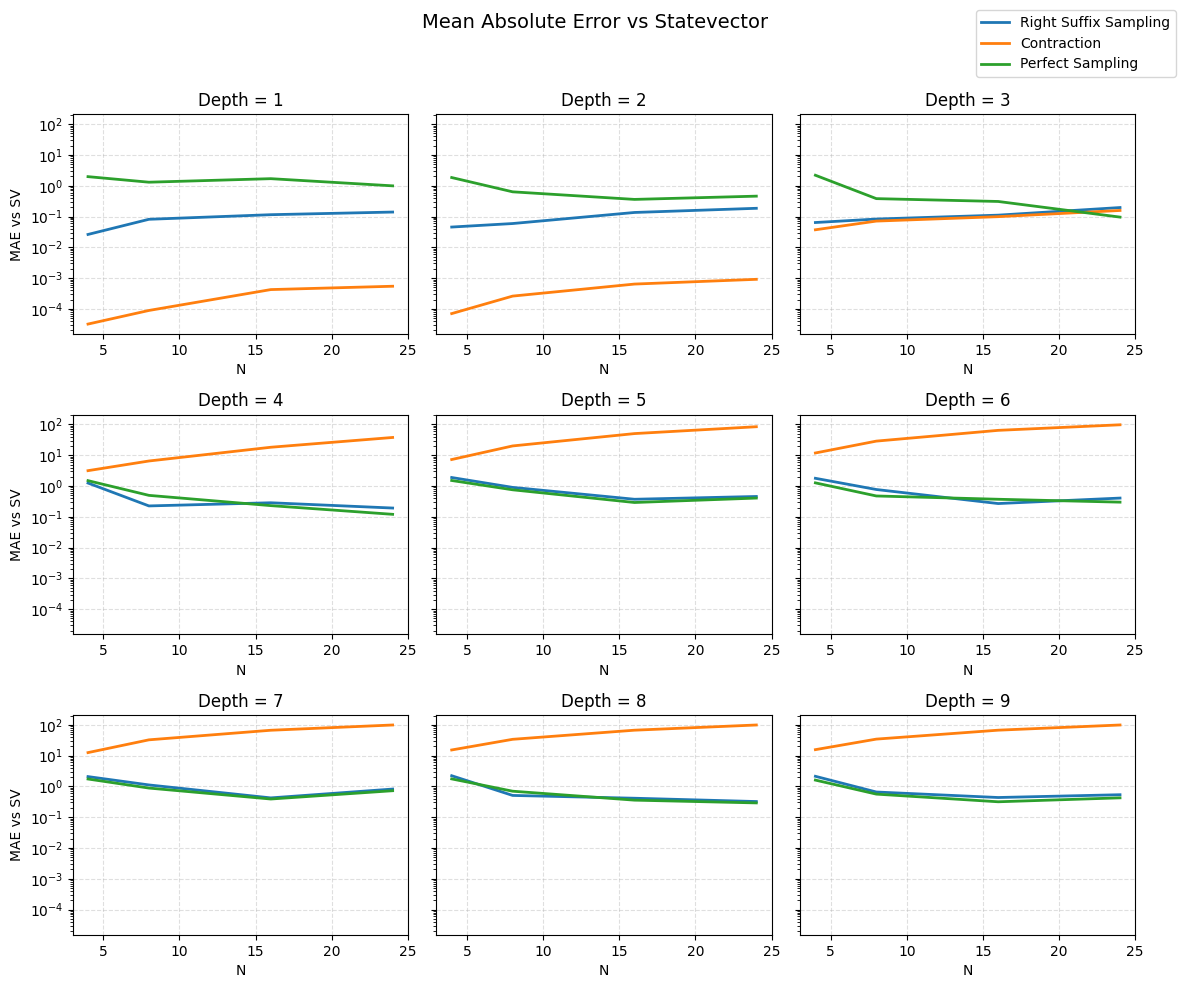

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_path = "init_expvals_full.csv"
df = pd.read_csv(csv_path)

# ------- adjust names here if needed -------
COL_METHOD = "method"
COL_N = "N"
COL_DEPTH = "depth"
COL_SEED = "seed"
COL_EXP = "exp_value"
SV_NAME = "sv"
# ------------------------------------------

df[COL_N] = df[COL_N].astype(int)
df[COL_DEPTH] = df[COL_DEPTH].astype(int)

# 1) split
df_sv = df[df[COL_METHOD] == SV_NAME].copy()
df_m  = df[df[COL_METHOD] != SV_NAME].copy()

# 2) make SV unique per (N, depth, seed)
#    if there are duplicates, we just average them
df_sv_uniq = (
    df_sv.groupby([COL_N, COL_DEPTH, COL_SEED])[COL_EXP]
         .mean()                      # or .first()
         .reset_index()
         .rename(columns={COL_EXP: "sv_val"})
)

# 3) merge
df_join = df_m.merge(
    df_sv_uniq,
    on=[COL_N, COL_DEPTH, COL_SEED],
    how="left"
)

# 4) MAE
df_join["abs_err"] = (df_join[COL_EXP] - df_join["sv_val"]).abs()

# 5) aggregate over seeds
g = (
    df_join
    .groupby([COL_METHOD, COL_DEPTH, COL_N])["abs_err"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
g["stderr"] = g["std"] / np.sqrt(g["count"]).replace(0, np.nan)

methods = list(g[COL_METHOD].unique())
method_labels = {}
for m in methods:
    low = m.lower()
    if "tr_correct_sampling" in low:
        method_labels[m] = "Right Suffix Sampling"
    elif "tr_expectation" in low:
        method_labels[m] = "Contraction"
    elif "tr_sampling" in low:
        method_labels[m] = "Perfect Sampling"

# 6) plot 3×3
depths = list(range(1, 10))
fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharey=True)
fig.suptitle("Mean Absolute Error vs Statevector", fontsize=14)

for idx, d in enumerate(depths):
    ax = axes[idx // 3, idx % 3]
    ax.set_title(f"Depth = {d}")

    ddf = g[g[COL_DEPTH] == d]
    if ddf.empty:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_axis_off()
        continue

    for m in methods:
        mdf = ddf[ddf[COL_METHOD] == m].sort_values(COL_N)
        if mdf.empty:
            continue

        ax.plot(
            mdf[COL_N],
            mdf["mean"],
            lw=2,
            label=method_labels[m],
        )
        # optional error band
        # ax.fill_between(
        #     mdf[COL_N],
        #     mdf["mean"] - mdf["stderr"],
        #     mdf["mean"] + mdf["stderr"],
        #     alpha=0.15,
        # )

    ax.set_xlabel("N")
    if idx % 3 == 0:
        ax.set_ylabel("MAE vs SV")
    ax.grid(True, ls="--", alpha=0.4)
    ax.set_yscale("log")
# single legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.99, 0.99))

plt.tight_layout(rect=[0, 0, 0.97, 0.95])
plt.show()
